# Laboratorium 4

### Konfiguracja

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
         
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
    
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
     
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

### Przykłady użycia

##### Proste rysowanie

Należy utworzyć zmienną z obiuektem `Plot`, który przyjmuje jako parametr konstruktora listę scen lub string ze scenami w formacie json. Następnie po dodaniu wszystkich, na samym końcu programu, należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


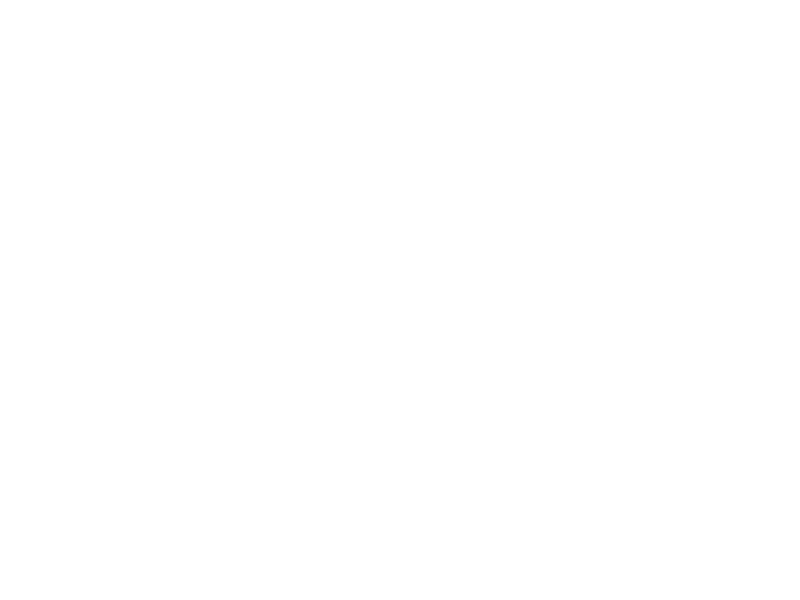

In [3]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)
plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

<IPython.core.display.Javascript object>


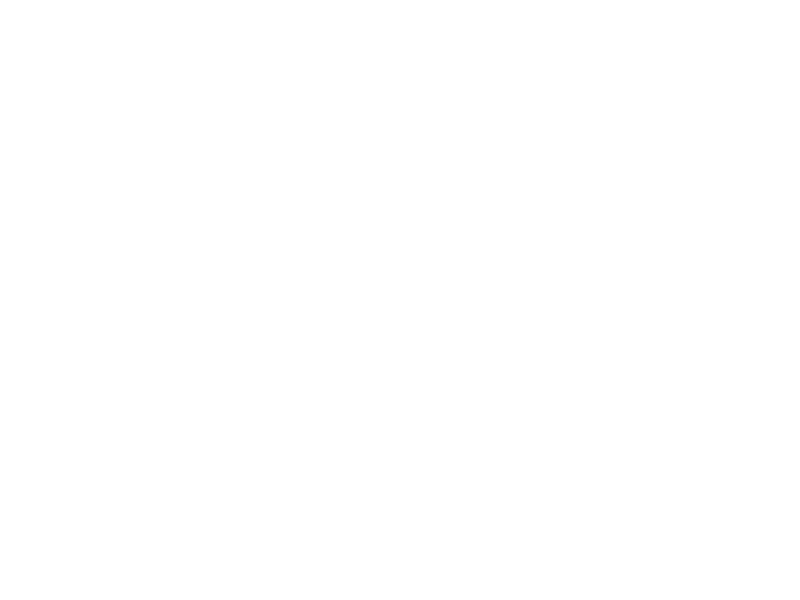

In [4]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.txt: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

<IPython.core.display.Javascript object>


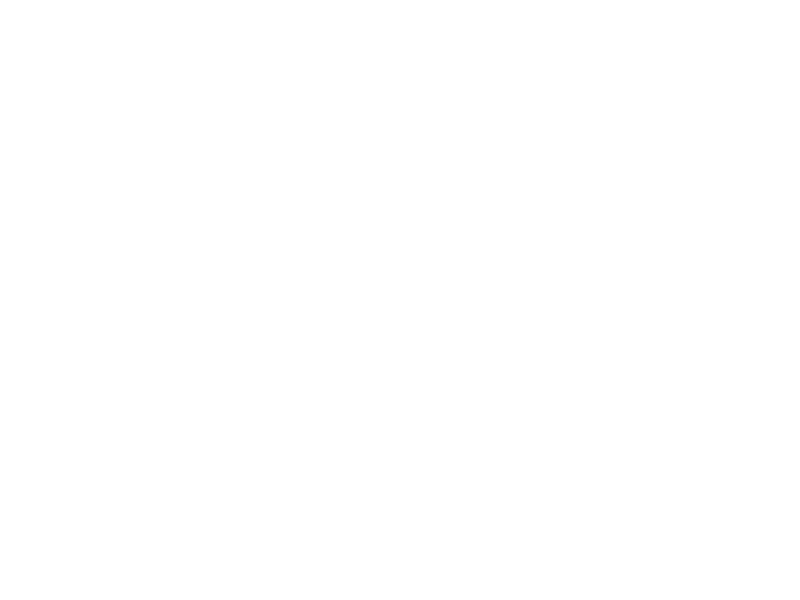

In [5]:
#Dodaj tu punkty, figury i/lub odcinki!
plot1 = Plot()
plot1.draw()

<IPython.core.display.Javascript object>


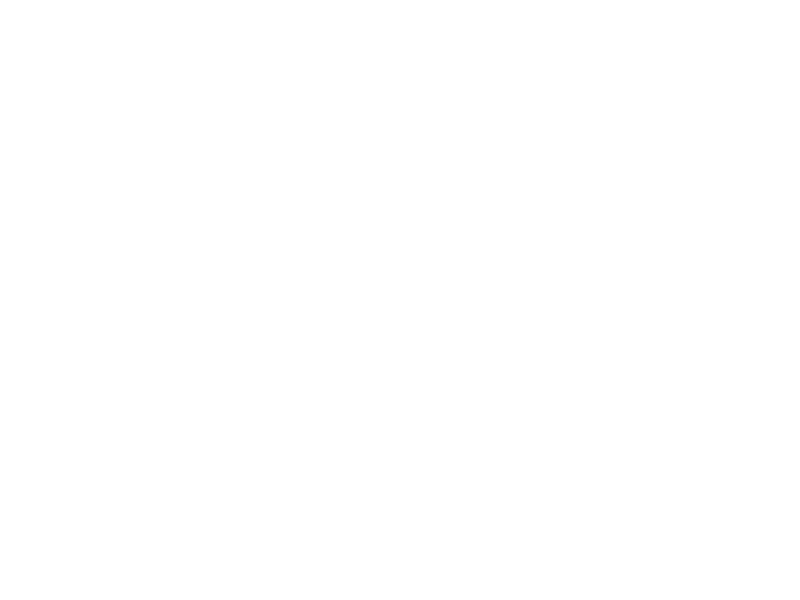

In [6]:
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()

### Rozwiązanie

In [61]:
def det3(a,b,c):
    return a.x*b.y + a.y*c.x + b.x*c.y - b.y*c.x - a.y*b.x - a.x*c.y

CORRECT = 0
STARTING = 1
ENDING = 2
CONNECTING = 3
DIVIDING = 4

LEFT = 0
RIGHT = 1

class Vertex:
    def __init__(self, point):
        self.x = point[0]
        self.y = point[1]
        self.left = self
        self.right = self
        self.mode = None
        self.chain = None
    def toTuple(self):
        return (self.x, self.y)
    def setMode(self):
        sgnLeft = self.left.y - self.y
        sgnRight = self.right.y - self.y 
        if sgnLeft*sgnRight < 0:
            self.mode = CORRECT
        else:
            det = det3(self.left, self, self.right)
            if sgnLeft > 0:
                if det > 0:
                    self.mode = ENDING
                else:
                    self.mode = CONNECTING
            else:
                if det < 0:
                    self.mode = DIVIDING
                else:
                    self.mode = STARTING

In [57]:
EPSILON = 10**(-15)

class Polygon:
    def __init__(self, lines):
        self.root = Vertex(lines.lines[0][0])
        for l in lines.lines[1:]:
            node = Vertex(l[0])
            self.root.left.right = node
            node.left = self.root.left
            node.right = self.root
            self.root.left = node
            
    def findMinVertexY(self):
        actVertex = self.root
        minVertex = self.root
        while actVertex.right != self.root:
            actVertex = actVertex.right
            if abs(actVertex.y - minVertex.y) < EPSILON and actVertex.y < minVertex.y:
                minVertex = actVertex
        return minVertex
    
    def findMaxVertexY(self):
        actVertex = self.root
        maxVertex = self.root
        while actVertex.right != self.root:
            actVertex = actVertex.right
            if abs(actVertex.y - maxVertex.y) < EPSILON and actVertex.y > maxVertex.y:
                maxVertex = actVertex
        return maxVertex
    
    def isMonotonicY(self):
        minVertex = self.findMinVertexY()
        actVertex = minVertex
        while actVertex.y <= actVertex.right.y:
            actVertex = actVertex.right
        while actVertex.y >= actVertex.right.y:
            actVertex = actVertex.right
        return actVertex.y == minVertex.y
    
    def classifyVertices(self):
        actVertex = self.root
        while True:
            actVertex.setMode()
            actVertex = actVertex.right
            if actVertex == self.root:
                break
            
    def showPoints(self):
        corr = PointsCollection([], color = "brown")
        start = PointsCollection([], color = "green")
        end = PointsCollection([], color = "red")
        conn = PointsCollection([], color = "blue")
        div = PointsCollection([], color = "pink")
        actVertex = self.root
        while True:
            if actVertex.mode == CORRECT: 
                corr.add_points([actVertex.toTuple()])
            elif actVertex.mode == STARTING: 
                start.add_points([actVertex.toTuple()])
            elif actVertex.mode == ENDING: 
                end.add_points([actVertex.toTuple()])
            elif actVertex.mode == CONNECTING: 
                conn.add_points([actVertex.toTuple()])
            elif actVertex.mode == DIVIDING: 
                div.add_points([actVertex.toTuple()])
            actVertex = actVertex.right
            if actVertex == self.root:
                break
        return [corr, start, end, conn, div]
    
    def triangulate(self):
        if not self.isMonotonicY:
            return None
        maxVertex = self.findMaxVertexY()
        minVertex = self.findMinVertexY()
        pointsStack = [maxVertex]
        triangles = []
        
        actLeft = maxVertex.left
        while actLeft != minVertex:
            actLeft.chain = LEFT
            
        actRight = maxVertex.right
        while actRight != minVertex:
            actRight.chain = RIGHT
        
        actLeft = maxVertex.left
        actRight = maxVertex.right
        
        if actLeft.y > actRight.y:
            pointsStack.append(actLeft)
            actLeft = actLeft.left
        else:
            pointsStack.append(actRight)
            actRight = actRight.right
        
        while actLeft != minVertex or actRight != minVertex:
            actual = max([actLeft, actRight], key = lambda p: p.y)
            if actual.chain != pointsStack[-1].chain:
                if actual.chain == LEFT:
                    triangles.append([actual.toTuple(), pointsStack[-1].toTuple(), pointsStack[-2].toTuple()])
                    actLeft = actLeft.left
                else:
                    triangles.append([actual.toTuple(), pointsStack[-2].toTuple(), pointsStack[-1].toTuple()])
                    actRight = actRight.right
                pointsStack = [pointsStack[-1], actual]
            else:
                if actual.chain == LEFT:
                    det = det3(actual.toTuple(), pointsStack[-1].toTuple(), pointsStack[-2].toTuple())
                    if abs(det) < EPSILON or det > 0:
                        pointsStack.append(actual)
                    else:
                        pass
                        
                        
                    
            
        
        
        

In [35]:
def loadPolygons(plot):
    return Polygon(plot.get_added_elements().lines[0])

<IPython.core.display.Javascript object>


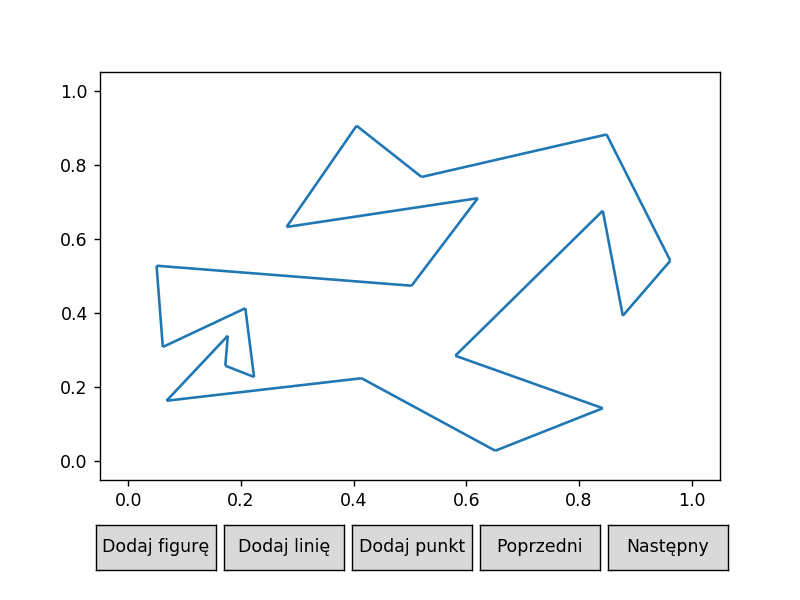

In [64]:
%matplotlib notebook

plot = Plot()
plot.draw()

In [65]:
poly = loadPolygons(plot)
print(poly.isMonotonicY())

False


<IPython.core.display.Javascript object>


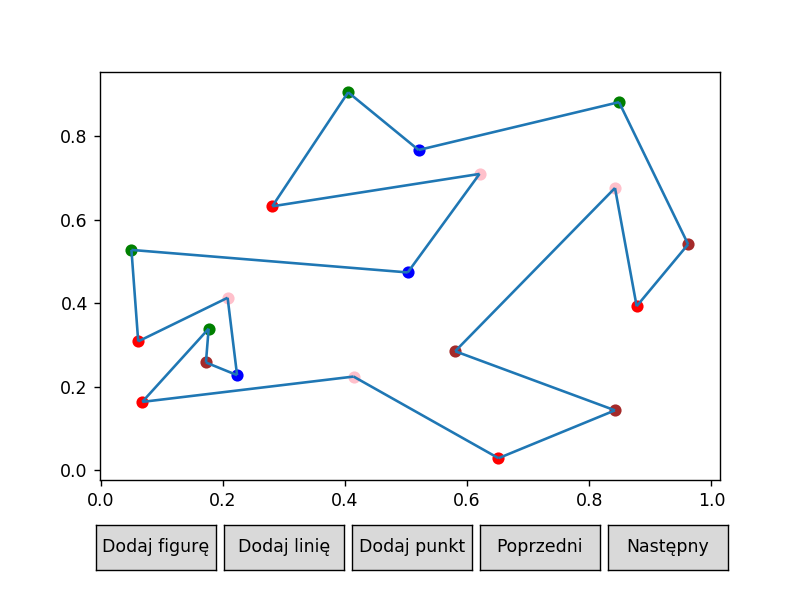

In [67]:
poly.classifyVertices()
plot1 = Plot([Scene(poly.showPoints(), [plot.get_added_elements().lines[0]])])
plot1.draw()